In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

In [28]:
L = 1.
NX = NY = 64
X_START = 0.
X_END = L
Y_START = 0.
Y_END = L
TOL = 1e-5

In [29]:
x = jnp.linspace(X_START, X_END, NX + 1)
y = jnp.linspace(Y_START, Y_END, NY + 1)
X, Y = jnp.meshgrid(x, y)

In [30]:
dx = x[1] - x[0]
dy = y[1] - y[0]

In [31]:
u = jax.jit(lambda x, y: (x**2 - 1.)*(y**2 - 1.))
f = jax.jit(lambda x, y: -2.*(2. - x**2 - y**2))

In [32]:
U = u(X, Y)
F = f(X, Y)

In [33]:
u_init = U.at[1:-1,1:-1].set(0)

In [34]:
@jax.jit
def residual_node_compute(i, j, u=u_init, f=F, dx=dx, dy=dy):
    u_ijm1, u_ij, u_ijp1, u_im1j, u_ip1j, f_ij = u[i,j - 1], u[i,j],  u[i,j + 1], u[i - 1,j], u[i + 1,j], f[i,j]
    return f_ij - (u_ijp1 - 2*u_ij + u_ijm1)/dx**2 - (u_ip1j - 2*u_ij + u_im1j)/dy**2

@jax.jit
def q_node_compute(i, j, u, dx=dx, dy=dy):
    u_ijm1, u_ij, u_ijp1, u_im1j, u_ip1j = u[i,j - 1], u[i,j],  u[i,j + 1], u[i - 1,j], u[i + 1,j]
    return (u_ijp1 - 2*u_ij + u_ijm1)/dx**2 + (u_ip1j - 2*u_ij + u_im1j)/dy**2

In [35]:
rnci_vmapped = jax.vmap(jax.vmap(residual_node_compute, in_axes=(None, 0)), in_axes=(0, None))
r_init = jnp.zeros_like(u_init)
r_init = r_init.at[1:-1, 1:-1].set(rnci_vmapped(jnp.arange(1,NX), jnp.arange(1,NY)))
p_init = r_init.clone()
rms_init = jnp.sqrt(jnp.average(jnp.square(r_init)))

In [36]:
urp_init = jnp.stack((u_init, r_init, p_init), axis=0)

In [45]:
def cg_main_loop(urp, index_arr_x=jnp.arange(1,NX), index_arr_y=jnp.arange(1,NY)):
    u, r, p = urp
    
    q = jnp.zeros_like(p)
    q = q.at[1:-1, 1:-1].set(jax.vmap(jax.vmap(q_node_compute, in_axes=(None, 0, None)),\
                            in_axes=(0, None, None))\
                            (index_arr_x, index_arr_y, p))
    rho = jnp.sum(r * r)
    alpha = rho/jnp.sum(p * q)
    
    u = u.at[1:-1, 1:-1].add(alpha * p[1:-1, 1:-1])
    r = r.at[1:-1, 1:-1].add(-alpha * q[1:-1, 1:-1])
    
    rho_new = jnp.sum(r * r)
    beta = rho_new/rho
    p = p.at[1:-1, 1:-1].set(r[1:-1, 1:-1] + beta * p[1:-1, 1:-1])

    return jnp.stack((u, r, p), axis=0)
    
def tol_check_(urp, U = U, TOL=TOL):
    u, _, __ = urp
    return jnp.average(jnp.absolute(u - U)) > TOL    

def tol_check(urp, TOL=1e-2):
    _, r, __ = urp
    return jnp.sqrt(jnp.average(jnp.square(r))) > TOL    

In [46]:
u_num = jax.lax.while_loop(tol_check, cg_main_loop, urp_init)

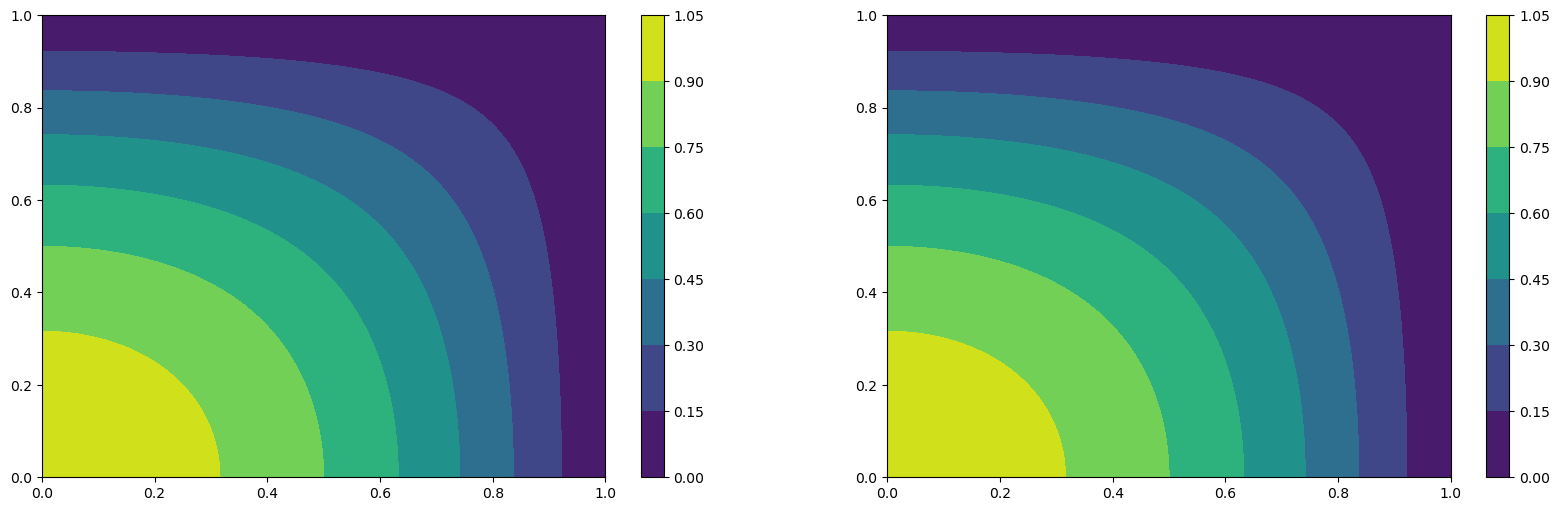

In [47]:
fig, axs = plt.subplots(1,2, figsize=(20, 6))
true = axs[0].contourf(X, Y, U)
num = axs[1].contourf(X, Y, u_num[0].reshape(NX+1,NX+1))

fig.colorbar(true)
fig.colorbar(num)
plt.show()

In [48]:
jnp.average(jnp.absolute(u_num[0] - U))

Array(1.0577418e-05, dtype=float32)